In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
import scipy
import cv2
import os

In [143]:
benign_count = 0
anom_count = 0

In [144]:
def convert_to_images(df, label_name, feature_count):
    global benign_count, anom_count

    counter = 0
    chunk_size = feature_count * 3
    chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    output_dir = os.path.join("converted_images", str(label_name))
    os.makedirs(output_dir, exist_ok=True)

    for idx, chunk in enumerate(chunks):
        if len(chunk) != chunk_size:
            continue

        img = np.zeros((feature_count, feature_count, 3), dtype=np.uint8)

        # Process each channel (R, G, B)
        for channel in range(3):
            channel_data = chunk.iloc[channel*feature_count : (channel+1)*feature_count]
            channel_processed = np.nan_to_num(channel_data, nan=0.0, posinf=255.0, neginf=0.0)
            channel_processed = np.clip(channel_processed, 0, 255).astype(np.uint8)
            img[:, :, channel] = channel_processed

        filename = os.path.join(output_dir, f"{label_name}_{counter}.png")
        cv2.imwrite(filename, img)
        
        if label_name == 'Benign':
            benign_count += 1
        else:
            anom_count += 1
        counter += 1

In [145]:
df = pd.read_parquet(r"C:\Users\John Rome Belocora\Downloads\01-12-20250510T145443Z-1-001\01-12\Syn.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155875 entries, 0 to 155874
Data columns (total 78 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  155875 non-null  int64  
 1   Flow Duration             155875 non-null  int64  
 2   Total Fwd Packets         155875 non-null  int64  
 3   Total Backward Packets    155875 non-null  int64  
 4   Fwd Packets Length Total  155875 non-null  float64
 5   Bwd Packets Length Total  155875 non-null  float64
 6   Fwd Packet Length Max     155875 non-null  float64
 7   Fwd Packet Length Min     155875 non-null  float64
 8   Fwd Packet Length Mean    155875 non-null  float64
 9   Fwd Packet Length Std     155875 non-null  float64
 10  Bwd Packet Length Max     155875 non-null  float64
 11  Bwd Packet Length Min     155875 non-null  float64
 12  Bwd Packet Length Mean    155875 non-null  float64
 13  Bwd Packet Length Std     155875 non-null  f

In [146]:
benign_count = 0
anom_count = 0

In [147]:
print("Unique labels:", df['Label'].unique())

Unique labels: ['Syn' 'BENIGN']


In [148]:
print(df['Label'].value_counts())

Label
Syn       155501
BENIGN       374
Name: count, dtype: int64


In [149]:
# Prepare features and get feature count
label_col = 'Label'
features = df.drop(columns=[label_col])
feature_count = features.shape[1]

In [10]:
# Print initial counts
print(f"Initial Counts - Anomalous: {anom_count}, Benign: {benign_count}")

Initial Counts - Anomalous: 0, Benign: 0


In [11]:
# Process all labels
for label in df[label_col].unique():
    class_data = df[df[label_col] == label].drop(columns=[label_col])
    convert_to_images(class_data, label, feature_count)

print(f"Benign Images After: {benign_count}")
print(f"Anomalous Images After: {anom_count}")

Benign Images After: 0
Anomalous Images After: 674


In [13]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
print(tf.test.is_gpu_available())  

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [14]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Should return True
print(tf.sysconfig.get_build_info())  # Check CUDA/cuDNN versions

True
OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


# Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = True 
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

img_size = (224, 224) 
input_shape = (*img_size, 3)

In [75]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r"C:\Users\John Rome Belocora\Downloads\new_converted_images"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20, 
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.9, 1.1],  # subtle brightness variation
    zoom_range=0.1,  # slight zoom
    horizontal_flip=True 
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 1122 images belonging to 16 classes.
Found 274 images belonging to 16 classes.


In [77]:
num_classes = len(train_generator.class_indices)
resnet_model = create_resnet_model(input_shape, num_classes)

history = resnet_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15),
        tf.keras.callbacks.ModelCheckpoint('best_new_resnet.h5', save_best_only=True)
    ]
)

test_loss, test_acc = resnet_model.evaluate(val_generator)
print(f"Test accuracy: {test_acc:.2%}")

Epoch 1/100
71/71 [==============================] - 26s 282ms/step - loss: 2.0537 - accuracy: 0.6925 - val_loss: 3.8847 - val_accuracy: 0.3102
Epoch 2/100
71/71 [==============================] - 15s 206ms/step - loss: 1.2391 - accuracy: 0.8824 - val_loss: 4.2088 - val_accuracy: 0.3102
Epoch 3/100
71/71 [==============================] - 15s 207ms/step - loss: 1.2075 - accuracy: 0.8859 - val_loss: 4.1490 - val_accuracy: 0.3102
Epoch 4/100
71/71 [==============================] - 15s 207ms/step - loss: 1.1047 - accuracy: 0.9135 - val_loss: 5.1966 - val_accuracy: 0.3102
Epoch 5/100
71/71 [==============================] - 15s 207ms/step - loss: 1.1028 - accuracy: 0.9118 - val_loss: 6.1797 - val_accuracy: 0.3175
Epoch 6/100
71/71 [==============================] - 15s 206ms/step - loss: 1.0360 - accuracy: 0.9251 - val_loss: 5.6270 - val_accuracy: 0.3212
Epoch 7/100
71/71 [==============================] - 15s 207ms/step - loss: 1.0457 - accuracy: 0.9251 - val_loss: 6.2294 - val_accuracy:

In [78]:
def predict_attack_type(img_path):
    img = image.load_img(img_path, target_size=img_size)  # Now uses (224, 224)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    pred = resnet_model.predict(img_array)
    class_idx = np.argmax(pred)
    class_labels = list(train_generator.class_indices.keys())
    return class_labels[class_idx], pred[0][class_idx]

1/1 [==============================] - 0s 20ms/step


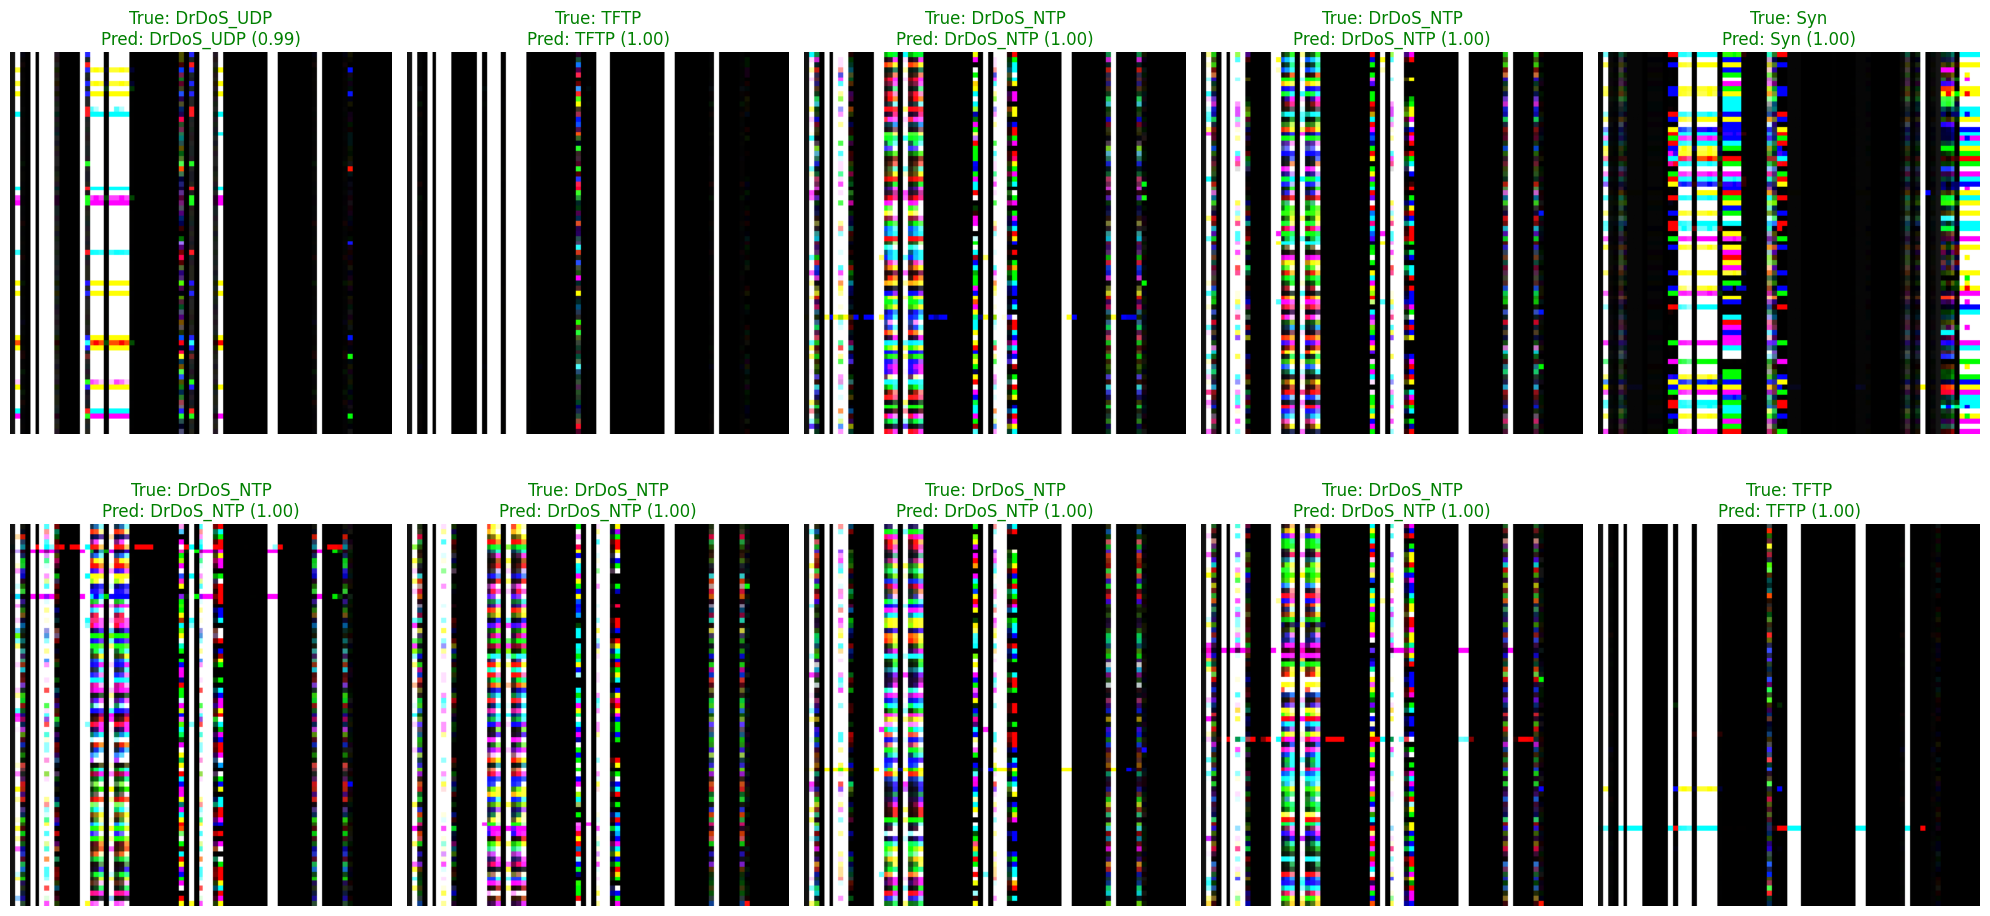

In [90]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

def visualize_predictions(test_images_dir, num_samples=10, img_size=(224, 224)):
    # Get all image files
    image_files = []
    for root, dirs, files in os.walk(test_images_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    
    if not image_files:
        print(f"No images found in {test_images_dir}")
        return
    
    # Select random samples
    selected_images = np.random.choice(image_files, size=min(num_samples, len(image_files)), replace=False)
    
    # Create figure
    fig, axes = plt.subplots(2, (num_samples + 1) // 2, figsize=(20, 10))
    axes = axes.flat
    
    for i, img_path in enumerate(selected_images):
        if i >= len(axes):
            break
            
        try:
            # Make prediction
            true_label = os.path.basename(os.path.dirname(img_path))
            predicted_label, confidence = predict_attack_type(img_path)

            # Load and plot the image
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img) / 255.0
            axes[i].imshow(img_array)
            
            # Set title based on prediction
            color = "green" if predicted_label == true_label else "red"
            axes[i].set_title(f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f})", color=color)
            axes[i].axis("off")
        
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            axes[i].axis("off")
            axes[i].set_title("Error loading image")
    
    plt.tight_layout()
    plt.show()

visualize_predictions(r"C:\Users\John Rome Belocora\Downloads\new_converted_images")

In [277]:
from tensorflow.keras.models import load_model
import tensorflow as tf

try:
    model = load_model(r"C:\Users\John Rome Belocora\Downloads\Models\resnet_model.h5", compile=False)
    # Recompile with original settings
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("ResNet model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

ResNet model loaded successfully!


In [278]:
data_dir = r"C:\Users\John Rome Belocora\Downloads\new_converted_images"
img_size = (224, 224)  # Must match your ResNet training size

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Must match your training split
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=16,  # Match your ResNet training batch size
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Critical for correct label alignment
)

Found 274 images belonging to 16 classes.


In [281]:
if model_classes != val_classes:
    print("\nWarning: Class mismatch between model and validation data!")
    print("Only evaluating on classes the model was trained on...")
    
    # Filter validation samples to only include model's classes
    val_indices = [i for i, label in enumerate(val_generator.classes) if label < model_classes]
    
    # Get all batches and filter
    all_images = []
    all_labels = []
    val_generator.reset()
    for _ in range(len(val_generator)):
        x, y = next(val_generator)
        all_images.append(x)
        all_labels.append(y.argmax(axis=1))
    
    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels)
    
    # Filter to only model's classes
    filter_mask = all_labels < model_classes
    filtered_images = all_images[filter_mask]
    filtered_labels = all_labels[filter_mask]
    
    y_pred = model.predict(filtered_images).argmax(axis=1)
    y_true = filtered_labels
    
else:
    # If classes match, proceed normally
    val_generator.reset()
    y_true = val_generator.classes
    y_pred = model.predict(val_generator).argmax(axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred,
    labels=range(model_classes),
    target_names=class_names[:model_classes],
    digits=4
))

18/18 [==============================] - 2s 92ms/step

Classification Report:
               precision    recall  f1-score   support

    DrDoS_DNS     1.0000    1.0000    1.0000         3
   DrDoS_LDAP     0.0000    0.0000    0.0000         1
  DrDoS_MSSQL     0.3333    0.8000    0.4706         5
    DrDoS_NTP     1.0000    1.0000    1.0000       105
DrDoS_NetBIOS     0.0000    0.0000    0.0000         0
   DrDoS_SNMP     0.5000    0.5000    0.5000         2
    DrDoS_UDP     0.5000    0.7778    0.6087         9
         LDAP     0.0000    0.0000    0.0000         1
        MSSQL     1.0000    0.2857    0.4444         7
      NetBIOS     0.0000    0.0000    0.0000         0
      Portmap     0.0000    0.0000    0.0000         0
          Syn     1.0000    1.0000    1.0000        37
         TFTP     1.0000    0.9412    0.9697        85
          UDP     0.5455    0.5000    0.5217        12
      UDP-lag     0.8750    1.0000    0.9333         7
      WebDDoS     0.0000    0.0000    0.0

c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi